#Params
* NUM_CLIENTS = 20
* NUM_FIT = 5
* ROUNDS = 8
* server optim - SGD
* client optim - SGD

In [1]:
!pip install tensorflow_federated

In [2]:
import pandas as pd
import tensorflow as tf
import tensorflow_federated as tff
import keras
import keras.backend as K
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import collections
import random
import time
import math
import os

In [3]:
def create_dataset(data):
    #extracting features
    features = data.loc[:, ~data.columns.isin(["pm2.5", "pm10"])]
    #extracting labels
    targets = data.loc[:, data.columns.isin(["pm2.5", "pm10"])]
    #creating a timeseries datase
    return tf.keras.utils.timeseries_dataset_from_array(
        features.to_numpy(),
        targets.to_numpy(),
        #interval period, we have data at every 1 hour intervals
        sequence_length=1,
        #taking all rows into one
        batch_size=1,
        sequence_stride=1,
        shuffle=False
    )

In [4]:
#ref - https://machinelearningmastery.com/adding-a-custom-attention-layer-to-recurrent-neural-network-in-keras/
class Attention(keras.layers.Layer):
    def __init__(self,**kwargs):
        super(Attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1),
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1),
                               initializer='zeros', trainable=True)
        super(Attention, self).build(input_shape)

    def call(self,x):
        # Alignment scores. Pass them through tanh function
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)
        # Compute the weights
        alpha = K.relu(e)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context = x * alpha
        context = K.sum(context, axis=1)
        return context

In [5]:
def create_fl_clients(data, no_of_clients):
    '''
    data - pandas dataframe
    clients - number of FL clients to split the data
    '''
    datasets = []
    for cid in range(no_of_clients):
        #creating a partition value as per the number of FL clients
        partition_size = math.floor(len(data) / no_of_clients)
        #creating indexes to subset the dataframe
        idx_from, idx_to = int(cid) * partition_size, (int(cid) + 1) * partition_size
        #subsetting dataframe
        client_batch_data = data[idx_from:idx_to]
        #creates a interval timeseries dataset
        dataset = create_dataset(client_batch_data)
        datasets.append(dataset)

    return datasets

In [6]:
def model_fn():
    #declaring our input shape for model
    input_spec = collections.OrderedDict(
        #feature size
        x=tf.TensorSpec(shape=(None, None, input_size), dtype=tf.float64, name=None),
        #label size
        y=tf.TensorSpec(shape=(None, 2), dtype=tf.float64, name=None)
    )
    model = tf.keras.models.Sequential(
        [
            tf.keras.layers.Input(shape=(1, input_size)),
            tf.keras.layers.Conv1D(
                filters=50,
                kernel_size=5,
                strides=1,
                padding="causal",
              activation="relu"
            ),
            tf.keras.layers.LSTM(30, return_sequences=True),
            tf.keras.layers.LSTM(30, return_sequences=True),
            Attention(),
            tf.keras.layers.Dense(50, activation="relu"),
            tf.keras.layers.Dense(10, activation="relu"),
            tf.keras.layers.Dense(2),
        ]
    )
    return tff.learning.models.from_keras_model(
      model,
      input_spec = input_spec,
      loss=tf.keras.losses.MeanSquaredError(),
      metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [7]:
def train(trainer, train_data, val_data, test_data, num_rounds, no_of_clients, fit_on):
    #we want to set the federated learning params to be set to default
    state = trainer.initialize()
    #creating FL clients
    datasets = create_fl_clients(train_data, no_of_clients)
    #TODO: Randomly slecting clients
    random_datasets = random.choices(datasets, k=fit_on)
    #create model for evaluation
    eval = tff.learning.build_federated_evaluation(model_fn)
    #create timeseries datasets for validation and testing
    eval_client_data = create_dataset(val_data)
    test_client_data = create_dataset(test_data)

    #for plotting we declare arrays
    train_acc = []
    train_loss = []
    eval_acc = []
    eval_loss = []
    test_acc = []
    test_loss = []
    for n in range(num_rounds):
        #passing the new state with randomly chosen training dataset
        result = trainer.next(state, random_datasets)
        #setting new state for trained parameters
        state = result.state
        #declaring taining metrics
        train_metrics = result.metrics['client_work']['train']

        #using learning algorithm we pass the currrent state of round for evaluation
        eval_metrics = eval(trainer.get_model_weights(state), [eval_client_data])
        eval_metrics = eval_metrics['eval']

        #early stopping
        if(len(eval_acc) > 0 and eval_metrics['root_mean_squared_error'] >= eval_acc[-1]):
          break

        #using learning algorithm we pass the currrent state of round for testing
        test_metrics = eval(trainer.get_model_weights(state), [test_client_data])
        test_metrics = test_metrics['eval']

        print('Round:{a} Train - RMSE:{m:.2f}, Loss:{t:.2f} | Eval - RMSE:{b:.2f}, Loss:{c:.2f} | Test - RMSE:{d:.2f}, Loss:{e:.2f}'.format(
              a=n,
              m=train_metrics['root_mean_squared_error'],
              t=train_metrics['loss'],
              b=eval_metrics['root_mean_squared_error'],
              c=eval_metrics['loss'],
              d=test_metrics['root_mean_squared_error'],
              e=test_metrics['loss']
        ))

        #assigning metrics for plotting purposes
        train_acc.append(train_metrics['root_mean_squared_error'])
        train_loss.append(train_metrics['loss'])

        eval_acc.append(eval_metrics['root_mean_squared_error'])
        eval_loss.append(eval_metrics['loss'])

        test_acc.append(test_metrics['root_mean_squared_error'])
        test_loss.append(test_metrics['loss'])



    return train_acc, train_loss, eval_acc, eval_loss, test_acc, test_loss

In [8]:
import matplotlib
def plot(train_acc, train_loss, eval_acc, eval_loss, test_acc, test_loss):
  plt.plot(train_acc, label="Training")
  plt.plot(eval_acc, label="Evaluation")
  plt.plot(test_acc, label="Testing")
  plt.title("RMSE vs epochs")
  plt.xlabel("Rounds")
  plt.ylabel("RMSE")
  plt.legend()
  plt.gca().xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True, nbins=len(train_acc)))
  plt.show()

  plt.plot(train_loss, label="Training")
  plt.plot(eval_loss, label="Evaluation")
  plt.plot(test_loss, label="Testing")
  plt.title("Loss vs epochs")
  plt.xlabel("Rounds")
  plt.ylabel("Loss")
  plt.legend()
  plt.gca().xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True, nbins=len(train_acc)))
  plt.show()

In [9]:
def main(data, server_optimizer_fn, client_optimizer_fn, NUM_CLIENTS, NUM_FIT, ROUNDS, SERVER_LR, CLIENT_LR):
    #lengths for train test and validation sets 70-15-15
    total_samples = len(data)
    train_samples = int(0.7 * total_samples)
    val_samples = int(0.15 * total_samples)

    #subsetting the original data as per set lengths
    train_data = data[:train_samples]
    val_data = data[train_samples:train_samples + val_samples]
    test_data = data[train_samples + val_samples:]

    trainer = tff.learning.algorithms.build_weighted_fed_avg(
        model_fn,
        server_optimizer_fn,
        client_optimizer_fn,
    )

    train_acc, train_loss, eval_acc, eval_loss, test_acc, test_loss = train(
        trainer,
        train_data,
        val_data,
        test_data,
        num_rounds=ROUNDS,
        no_of_clients=NUM_CLIENTS,
        fit_on=NUM_FIT
    )

    return train_acc, train_loss, eval_acc, eval_loss, test_acc, test_loss

In [10]:
data = pd.read_csv('dublin_port.csv')
#dropping uncessary columns
data = data.drop(['datetime' ,'Unnamed: 0'], axis=1)

features = data.loc[:,~data.columns.isin(["pm2.5", "pm10"])]
label = data.loc[:,data.columns.isin(["pm2.5", "pm10"])]

#normalizing data
scaler = StandardScaler()
normalized_data = scaler.fit_transform(features)

norm_df = pd.DataFrame(normalized_data, columns=features.columns)

#combining normalized feature data with label columns
data = pd.concat([norm_df, label], axis=1)

#setting input size for model
input_size = len(features.columns)

In [11]:
#setting number of clients
NUM_CLIENTS = 20
NUM_FIT = 5
ROUNDS = 8

In [12]:
def optimizers(SERVER_LR, CLIENT_LR):
  server_optimizer_fn=lambda: tf.keras.optimizers.SGD(SERVER_LR, momentum=0.9)
  client_optimizer_fn=lambda: tf.keras.optimizers.SGD(CLIENT_LR, momentum=0.9)

  return server_optimizer_fn, client_optimizer_fn

<ipython-input-7-9df169d38e90>:9: DeprecationWarning: `tff.learning.build_federated_evaluation` is deprecated, use `tff.learning.algorithms.build_fed_eval` instead.
  eval = tff.learning.build_federated_evaluation(model_fn)


Round:0 Train - RMSE:7.75, Loss:60.01 | Eval - RMSE:13.84, Loss:191.63 | Test - RMSE:12.86, Loss:165.34
Round:1 Train - RMSE:7.19, Loss:51.65 | Eval - RMSE:13.07, Loss:170.74 | Test - RMSE:12.10, Loss:146.29
Round:2 Train - RMSE:6.69, Loss:44.80 | Eval - RMSE:11.59, Loss:134.32 | Test - RMSE:10.64, Loss:113.18
Round:3 Train - RMSE:6.32, Loss:39.98 | Eval - RMSE:9.33, Loss:86.99 | Test - RMSE:8.42, Loss:70.96
Round:4 Train - RMSE:6.13, Loss:37.53 | Eval - RMSE:6.93, Loss:48.06 | Test - RMSE:6.24, Loss:38.88
Round:5 Train - RMSE:6.09, Loss:37.03 | Eval - RMSE:6.61, Loss:43.67 | Test - RMSE:6.51, Loss:42.35


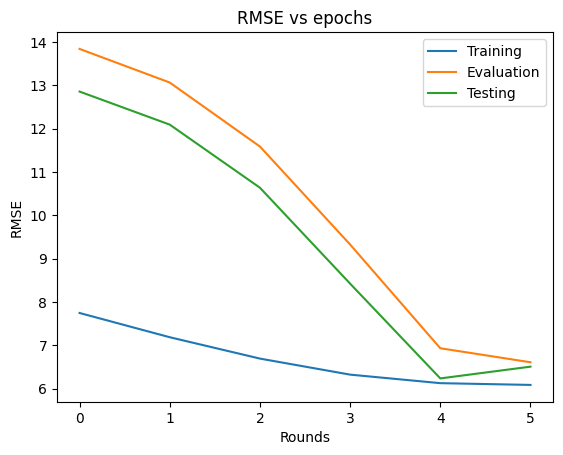

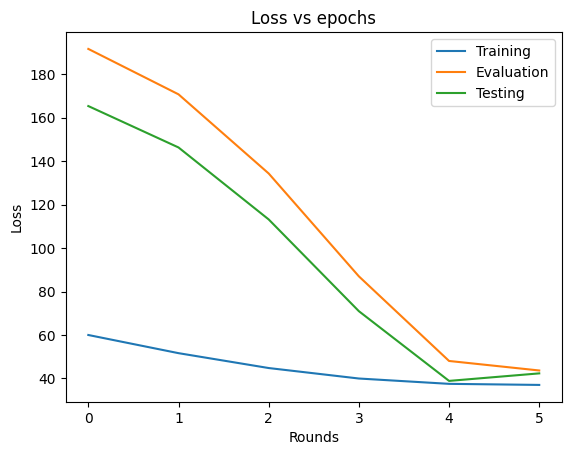

In [13]:
SERVER_LR = 0.0001
CLIENT_LR = 0.1

server_optimizer_fn, client_optimizer_fn = optimizers(SERVER_LR, CLIENT_LR)

train_acc1, train_loss1, eval_acc1, eval_loss1, test_acc1, test_loss1 = main(data,
                                                                       server_optimizer_fn,
                                                                       client_optimizer_fn,
                                                                       NUM_CLIENTS,
                                                                       NUM_FIT,
                                                                       ROUNDS,
                                                                       SERVER_LR,
                                                                       CLIENT_LR)

plot(train_acc1, train_loss1, eval_acc1, eval_loss1, test_acc1, test_loss1)

<ipython-input-7-9df169d38e90>:9: DeprecationWarning: `tff.learning.build_federated_evaluation` is deprecated, use `tff.learning.algorithms.build_fed_eval` instead.
  eval = tff.learning.build_federated_evaluation(model_fn)


Round:0 Train - RMSE:6.69, Loss:44.72 | Eval - RMSE:13.55, Loss:183.59 | Test - RMSE:12.56, Loss:157.77
Round:1 Train - RMSE:6.75, Loss:45.50 | Eval - RMSE:12.33, Loss:152.02 | Test - RMSE:11.35, Loss:128.81
Round:2 Train - RMSE:6.54, Loss:42.76 | Eval - RMSE:10.58, Loss:111.89 | Test - RMSE:9.62, Loss:92.56
Round:3 Train - RMSE:6.39, Loss:40.78 | Eval - RMSE:8.59, Loss:73.70 | Test - RMSE:7.70, Loss:59.28
Round:4 Train - RMSE:6.18, Loss:38.17 | Eval - RMSE:6.93, Loss:48.04 | Test - RMSE:6.25, Loss:39.03
Round:5 Train - RMSE:6.03, Loss:36.40 | Eval - RMSE:6.30, Loss:39.74 | Test - RMSE:5.98, Loss:35.70


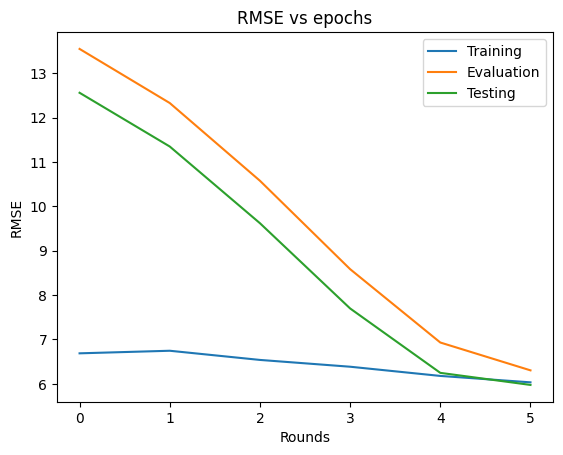

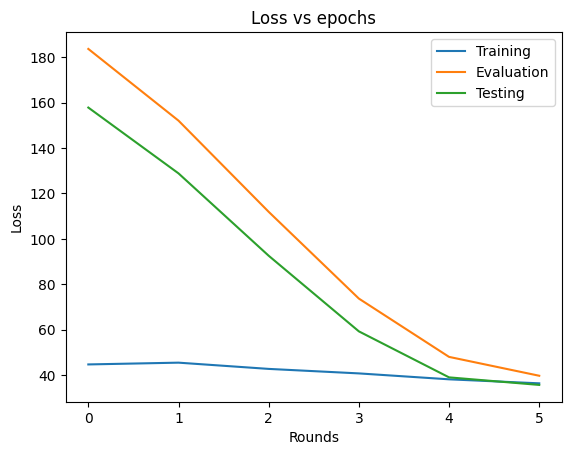

In [14]:
SERVER_LR = 0.001
CLIENT_LR = 0.1

server_optimizer_fn, client_optimizer_fn = optimizers(SERVER_LR, CLIENT_LR)

train_acc2, train_loss2, eval_acc2, eval_loss2, test_acc2, test_loss2 = main(data,
                                                                       server_optimizer_fn,
                                                                       client_optimizer_fn,
                                                                       NUM_CLIENTS,
                                                                       NUM_FIT,
                                                                       ROUNDS,
                                                                       SERVER_LR,
                                                                       CLIENT_LR)

plot(train_acc2, train_loss2, eval_acc2, eval_loss2, test_acc2, test_loss2)

<ipython-input-7-9df169d38e90>:9: DeprecationWarning: `tff.learning.build_federated_evaluation` is deprecated, use `tff.learning.algorithms.build_fed_eval` instead.
  eval = tff.learning.build_federated_evaluation(model_fn)


Round:0 Train - RMSE:6.86, Loss:47.04 | Eval - RMSE:13.04, Loss:170.15 | Test - RMSE:12.06, Loss:145.39
Round:1 Train - RMSE:6.81, Loss:46.41 | Eval - RMSE:11.13, Loss:123.80 | Test - RMSE:10.16, Loss:103.18
Round:2 Train - RMSE:6.69, Loss:44.69 | Eval - RMSE:8.87, Loss:78.68 | Test - RMSE:7.97, Loss:63.47
Round:3 Train - RMSE:6.55, Loss:42.94 | Eval - RMSE:6.98, Loss:48.71 | Test - RMSE:6.28, Loss:39.48
Round:4 Train - RMSE:6.45, Loss:41.63 | Eval - RMSE:6.30, Loss:39.74 | Test - RMSE:6.04, Loss:36.42


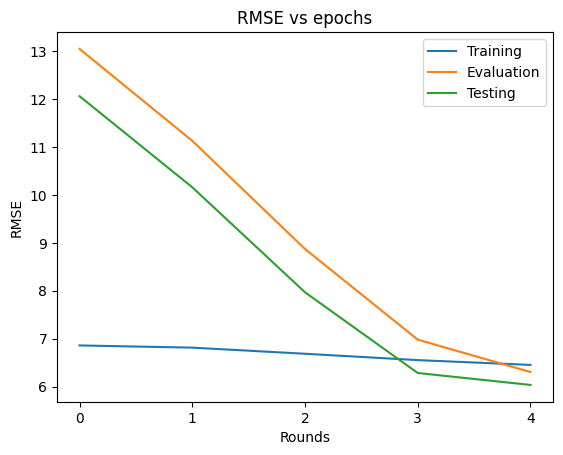

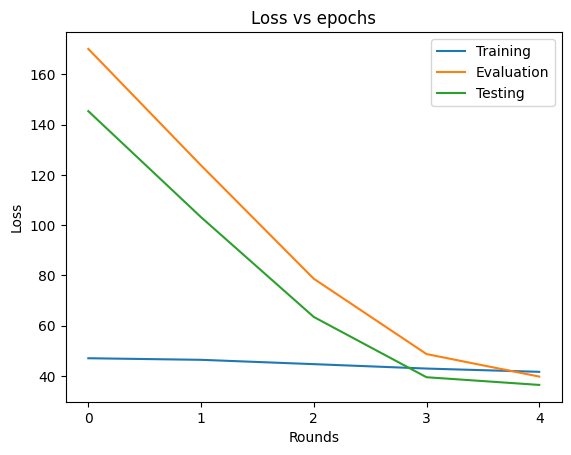

In [15]:
SERVER_LR = 0.01
CLIENT_LR = 0.1

server_optimizer_fn, client_optimizer_fn = optimizers(SERVER_LR, CLIENT_LR)

train_acc3, train_loss3, eval_acc3, eval_loss3, test_acc3, test_loss3 = main(data,
                                                                       server_optimizer_fn,
                                                                       client_optimizer_fn,
                                                                       NUM_CLIENTS,
                                                                       NUM_FIT,
                                                                       ROUNDS,
                                                                       SERVER_LR,
                                                                       CLIENT_LR)

plot(train_acc3, train_loss3, eval_acc3, eval_loss3, test_acc3, test_loss3)

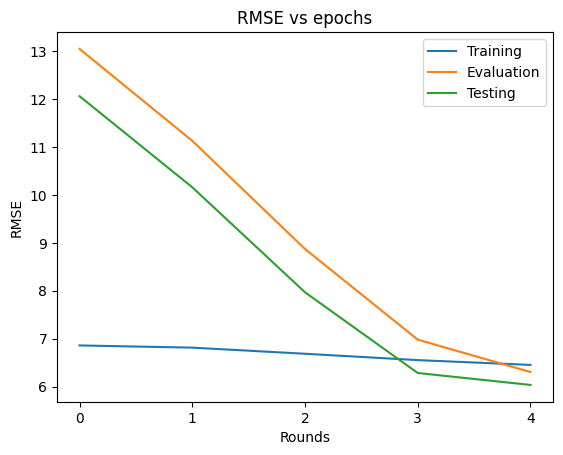

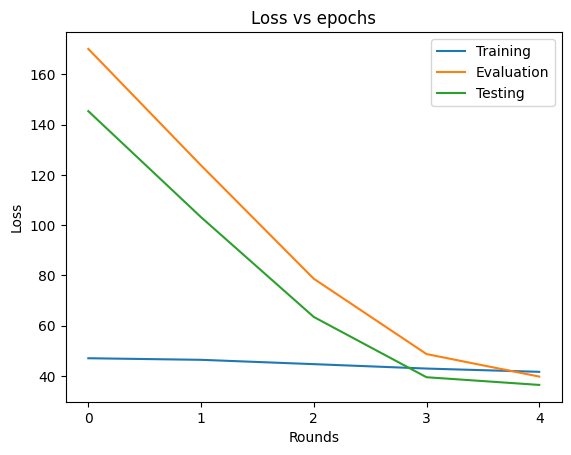

In [16]:
plot(train_acc3, train_loss3, eval_acc3, eval_loss3, test_acc3, test_loss3)

In [17]:
pd.DataFrame({
    "Train Clients": [NUM_FIT, NUM_FIT, NUM_FIT],
    "Epochs": [ROUNDS, ROUNDS, ROUNDS],
    "Server LR": ["0.0001", "0.001", "0.01"],
    "Client LR": [0.1, 0.1, 0.1],
    "Validation RMSE": [eval_acc1[-1], eval_acc2[-1], eval_acc3[-1]],
    "Test RMSE": [test_acc1[-1], test_acc2[-1], test_acc3[-1]]
})

,Train Clients,Epochs,Server LR,Client LR,Validation RMSE,Test RMSE
0,5,8,0.0001,0.1,6.608706,6.507384
1,5,8,0.001,0.1,6.303716,5.975345
2,5,8,0.01,0.1,6.303950,6.035106
